Hi,
I am looking for help on how to improve the model I have implemented. 

First I used gender surname model as mentioned by Chris Deotte [here](https://www.kaggle.com/c/titanic/discussion/57447), through which I acheived an accuracy of 81.8%.  I also checked the work done by Jack Roberts on using Ticket information ([link](https://www.kaggle.com/jack89roberts/titanic-using-ticket-groupings)). On using the ideas from these two approaches I could get an accuracy of 82.3% on the public leaderboard. A feature called GroupID was created taking into account the Ticket, Fare, PClass and Embarked features to segregate people into groups (this idea can be found in the comments of the previously mentioned kernel). Also, I liked the way Jack Roberts implemented the idea neatly in Python. So I tried to replicate his style in a few areas =D.

Go through this kernel if you want see how an accuracy of 82.3% can be acheived.

I would like to improve upon this model. I have recently started machine learning and don't want to get into complex models which involve stacking. I beleive new features have to be engineered to implement any tree based models. 

I would like to know whether I am missing any important information which can be used to improve the prediction accuracy. And if a machine learning model has to be used, how should I prepare the data for it (should I introduce new features, can the features which were used to get to 82.3% be used again in the model). (Also, please refer to the end of this kernel for a few more details.)


Thank You.

(** This is the first kernel I am making public. So please correct me if I have made any mistakes or if I have any areas to improve on including this intro =D**)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train, test = pd.read_csv('../input/train.csv'), pd.read_csv('../input/test.csv')
train.head()

**All men die except boys in whose family all females and boys survived. All females live except the ones in which all boys and females in the family die.**

In [ ]:
# Men who have the tag Master are classified as boys.
boys = train[train['Name'].str.contains('Master')]
females = train[train['Sex'] == 'female']

boy_or_female = boys | females

In [ ]:
#Creating a new feature called Surname
train['Surname'] = [train.iloc[i]['Name'].split(',')[0] for i in range(len(train))]
test['Surname'] = [test.iloc[i]['Name'].split(',')[0] for i in range(len(test))]

In [ ]:
# Survival rate of the boy-female groups grouped by surname.
boy_femSurvival = train.loc[boy_or_female.index].groupby('Surname')['Survived'].mean().to_frame()
boy_femSurvival

In [ ]:
# Boys survive in groups where all boys and females survive.
# Females die in the groups where all boys and females die.
boysSurvived = list(boy_femSurvival[boy_femSurvival['Survived'] == 1].index) # List of families (surname) where all boys and females survived.
femDie = list(boy_femSurvival[boy_femSurvival['Survived'] == 0].index) # List of families where all boys and females died.

In [ ]:
def createFeatures(frame):
    frame['Boy'] = frame['Name'].str.contains('Master').astype(int)
    frame['Female'] = (frame['Sex']=='female').astype(int) 
    return frame

def makePredictions(row):
    if row['Boy'] and (row['Surname'] in boysSurvived):
        return 1
        
    if row['Female']:
        if row['Surname'] in femDie:
            return 0
        else:
            return 1
            
    else:
        return 0

In [ ]:
test = createFeatures(test)
test.head()

In [ ]:
pred = test.apply(makePredictions, axis = 1)
sub = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':pred})
sub.to_csv('SurnameModel.csv', index = False)

**Leaderboard Score : 0.81818 **

Let's see how many predictions we made through the surname model.

In [ ]:
boy_count = 0
femCount = 0
for index, row in sub.iterrows():
    if test.iloc[index]['Sex'] == 'female' and row[1] == 0:
        print('femPassenger:',row[0])
        femCount = femCount + 1
    elif test.iloc[index]['Sex'] == 'male' and row[1] == 1:
        print('boy:',row[0])
        boy_count = boy_count + 1
print('BoyCount:',boy_count)
print('FemCount',femCount)

So we made a total of **17** predictions and the remaining men and women are predicted to have died and survived respectively.

In [ ]:
print(100*train.isnull().sum().sort_values(ascending = False)/len(train))

In [ ]:
test.isnull().sum().sort_values(ascending = False)

**Drop Cabin**. Too many missing values.

In [ ]:
train.drop('Cabin', axis = 1, inplace = True)
test.drop('Cabin', axis = 1, inplace = True)

In [ ]:
train[train['Embarked'].isnull() == True]

In [ ]:
train[train['Ticket'] == '113572']

In [ ]:
train[train['Surname'] == 'Icard']

**Here, we see that people who do not belong to the same family have the same ticket. This is possible as groups of friends also travel together. We'll see how we can make use of this.**

In [ ]:
ticketTrain = train.set_index('Ticket')

In [ ]:
train.groupby(['Ticket', 'Surname', 'Name'])['Survived'].mean().to_frame()

In [ ]:
frame = train.groupby(['Surname', 'Ticket','Fare','Pclass', 'Name', 'Embarked'])['Survived'].mean().to_frame()
frame

In [ ]:
frame.loc['Andersson']

Here, we notice a flaw with the approach of strictly considering surname. People with the same surname have different tickets, which means they are not together. So, we can't consider them to be in a group. So, we'll need a more stringent feature to create groups. Also with surnames we'll miss out on groups of friends, cousins etc.

Create a new feature called GroupID. Groupby the GroupID and create boy-female groups just as we have done earlier. Note that GroupID is a substitute for the Surname feature as it captures the groups that are traveling together more effectively.

In [ ]:
test['Embarked'].fillna('S', inplace = True)
test.isnull().sum().sort_values(ascending = False)

In [ ]:
test[test['Fare'].isnull()]

In [ ]:
test[test['Ticket'] == '3701']

** Considering that he is a male travelling alone, I guess it is reasonable to say that he will not survive.** Anyways, I will fill in his fare with the mean of Pclass 3's fare.

In [ ]:
fill = test[test['Pclass']==3]['Fare'].mean()
test['Embarked'].fillna(fill, inplace = True)

** Creating the new feature GroupID.** Which is a combination of the Pclass, Point of boarding, Ticket, fare. 

Also, the last character of ticket is not considered as people of the same group tend to have tickets which differ only in the last character. We don't want to miss out on such groups. (**Chris Deotte's Idea**)

In [ ]:
train['GroupID'] = train.apply(lambda row : str(row[8][:-1]) + '-' + str(row[2]) + '-' + str(row[9]) + str(row[10]), axis = 1)
test['GroupID'] = test.apply(lambda row : str(row[7][:-1]) + '-' + str(row[1]) + '-' + str(row[8]) + str(row[9]), axis = 1)
train

In [ ]:
GroupTable = train.pivot_table(index = 'GroupID', values = 'Survived', aggfunc=[len, np.mean])
GroupTable

In [ ]:
print('Number of unique surnames:',len(train['Surname'].unique()))
print('Number of groups (Families/ Friends ..):',len(train['GroupID'].unique()))

We find that the number of groups we found using only surname is more than the GroupID.  So we overcounted groups previously.

We will now repeat what we have done previously when we grouped by surname

In [ ]:
test.head()

In [ ]:
boy_femSurvival = train.loc[boy_or_female.index].groupby('GroupID')['Survived'].mean().to_frame()
boy_femSurvival.head()

In [ ]:
# These are the groups in which all the boys and females survived.
boysSurvived = list(boy_femSurvival[boy_femSurvival['Survived'] == 1].index)
print(len(boysSurvived))
boysSurvived

In [ ]:
# These are the groups in which all the females and boys died.
femDie = list(boy_femSurvival[boy_femSurvival['Survived'] == 0].index)
print(len(femDie))
femDie

We will have to make a few minor changes to the prediction function

In [ ]:
def makePredictions2(row):
    if row['Boy'] and (row['GroupID'] in boysSurvived):
        return 1
        
    if row['Female']:
        if row['GroupID'] in femDie:
            return 0
        else:
            return 1
            
    else:
        return 0

In [ ]:
pred2 = test.apply(makePredictions2, axis = 1)
sub = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':pred2})
sub.to_csv('TicketModel.csv', index = False)

**Leaderboard Score : 0.82296**

Let's check how many predictions we made.

In [ ]:
boy_count = 0
femCount = 0
for index, row in sub.iterrows():
    if test.iloc[index]['Sex'] == 'female' and row[1] == 0:
        print('femPassenger:',row[0])
        femCount = femCount + 1
    elif test.iloc[index]['Sex'] == 'male' and row[1] == 1:
        print('boy:',row[0])
        boy_count = boy_count + 1
print('BoyCount:',boy_count)
print('FemCount',femCount)

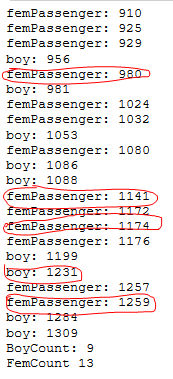

** The circled passengers are the new predictions made by the modified model. The rest were already predicted by the surname model. So, we can say that this supersets the surname approach.**

## How do we predict the fate of the remaining (418 - 22) passengers?

Our model now predicts that all men (excluding a few boys) die and the remaining females die. Can we build a better model by passing the remaining data to a ML model.

In [ ]:
print('Total number of females:',len(train[train['Sex'] == 'female']) + len(test[test['Sex'] == 'female']))
print('Percentage of females that survived in the train set:', len(train[(train['Sex']=='female') & (train['Survived']==1)])*100/len(train[train['Sex'] == 'female']))
print('Percentage of females that survived in the test set:', 100*(len(test[test['Sex'] == 'female'])-13)/len(test[test['Sex'] == 'female']))

In [ ]:
print('Total number of males:',len(train[train['Sex'] == 'male']) + len(test[test['Sex'] == 'male']))
print('Percentage of males that survived in the train set:', len(train[(train['Sex']=='male') & (train['Survived']==1)])*100/len(train[train['Sex'] == 'male']))
print('Percentage of males that survived in the test set:', 100*9/len(test[test['Sex'] == 'male']))

Clearly we have missed out on identifying features (combinations of features) which are prevalent in males who have survived.

** I believe that this cannot be done by using a random forest or any tree based model on the current set of features as we have probably got the most out of the current set. Also this approach is a group-based approach.**

** So, how can we engineer new features so that we can form better groups or is there an alternative approach to predicting the survival of the remaining passengers.** (By other I meant, not following a group based approach)